In [3]:
import scipy.io as io

graph_name = 'commanche_weighted'
mat_data = io.loadmat(graph_name + '.mat')

graph = mat_data['graph']
# graph = mat_data['Problem']['A'][0][0]
graph

<7920x7920 sparse matrix of type '<class 'numpy.float64'>'
	with 23760 stored elements in Compressed Sparse Column format>

In [5]:
import numpy as np
import scipy.sparse.csgraph as cs
import scipy.sparse as sparse

# choose landmark points by the MaxMin strategy from
# "Sparse multidimensional scaling using landmark points, Vin de Silva & Joshua B. Tenenbaum, 2004"
n = graph.shape[0]
numPivots = 200

p0 = np.random.randint(0,n)  # use one pivot
pivots = [p0]
sh_paths = {p0: cs.dijkstra(graph, indices=p0)}

# mins contains the min dist and which pivot it's from
mins = []
for i in range(n):
    mins.append([sh_paths[p0][i], p0])

for i in range(1,numPivots):
    
    # # normal max/min sp:
    # argmax = 0
    # for k in range(1,n):
    #     if mins[k][0] > mins[argmax][0]:
    #         argmax = k
    # pivots.append(argmax)

    # max/min random sp
    totalProb = 0
    cumulProb = []  # use cumulative prob distribution to sample
    for k in range(n):
        totalProb += mins[k][0]
        cumulProb.append(totalProb)
    sample = np.random.uniform(0, totalProb)
    for k in range(n):
        if sample < cumulProb[k]:
            pivots.append(k)
            break
            
    sh_paths[pivots[i]] = cs.dijkstra(graph, indices=pivots[i])
    for j in range(n):
        temp = sh_paths[pivots[i]][j]
        if temp < mins[j][0]:
            mins[j][0] = temp
            mins[j][1] = pivots[i]


In [6]:
# find the regions for each pivot
regions = {}
for p in pivots:
    regions[p] = []
    
for i in range(n):
    closestPivot = mins[i][1]
    regions[closestPivot].append(i)

In [7]:
# adjust the weights
weights = {}
constraints = []

for p in pivots:
    for i in range(n):
        if graph[p,i] == 0 and p != i:
            # THIS IS VERY SLOW, BUT WORKS AS AN EXAMPLE
            s = sum(1 for j in regions[p] if sh_paths[p][j] <= sh_paths[p][i]/2)
            w = 1/sh_paths[p][i]**2
            weights[(p,i)] = w
            weights[(i,p)] = s * w
            constraints.append((p,i,sh_paths[p][i])) 
             
    print('.', end='')

I,J,V = sparse.find(graph)
for e in range(len(I)):
    i,j,v = I[e],J[e],V[e]
    if i > j:
        weights[(i,j)] = weights[(j,i)] = 1/v**2
        constraints.append((i,j,graph[i,j]))

........................................................................................................................................................................................................

In [8]:
# determine annealing schedule
w_max = 0
w_min = float('inf')
for w in weights.values():
    w_min = min(w, w_min)
    w_max = max(w, w_max)

eta_max = 1 / w_min
eta_min = 0.1 / w_max
num_iter = 15
lambd = np.log(eta_min/eta_max) / (num_iter-1)

eta = lambda k: eta_max * np.exp(lambd*k)

print("{} {} {}".format(w_max, w_min, lambd))

69.4821409359889 6.10448224033581e-06 -1.325010150764982


In [9]:
import random
X = np.random.rand(n, 2)   

for k in range(num_iter):
    random.shuffle(constraints)
    c = eta(k)
    
    for i,j,d in constraints:
        w_i = min(weights[(i,j)]*c, 1)
        w_j = min(weights[(j,i)]*c, 1)
        ij = X[i] - X[j]
        mag = np.linalg.norm(ij)
        m = ((d-mag)/2) * (ij/mag)
        
        X[i] += w_i * m
        X[j] -= w_j * m
        
    print('.', end='')

...............

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


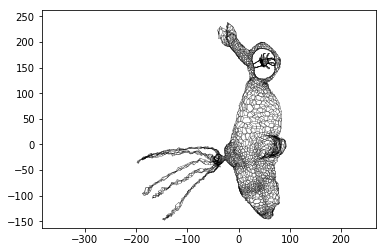

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

plt.axis('equal')
ax = plt.axes()
ax.set_xlim(min(X[:,0])-1, max(X[:,0])+1)
ax.set_ylim(min(X[:,1])-1, max(X[:,1])+1)

lines = []
for i,j in zip(*graph.nonzero()):
    lines.append([X[i], X[j]])

lc = mc.LineCollection(lines, linewidths=0.3, colors='k', alpha=.5)
ax.add_collection(lc)

plt.savefig(graph_name + '.svg', format='svg', dpi=1000)